AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)
Sample Rate: 44100
維度: (2, 109368)
資料型態: torch.float32
 - 最大值:          0.508
 - 最小值:         -0.449
 - 平均數:         0.000
 - 標準差:  0.118

tensor([[ 0.0027,  0.0063,  0.0092,  ...,  0.0032,  0.0047,  0.0052],
        [-0.0038, -0.0015,  0.0013,  ..., -0.0032, -0.0012, -0.0003]])



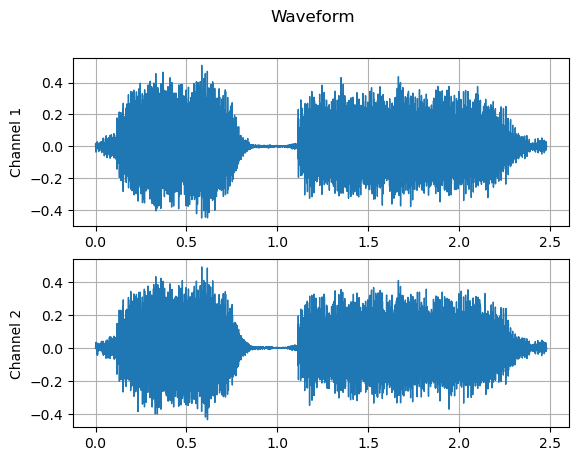

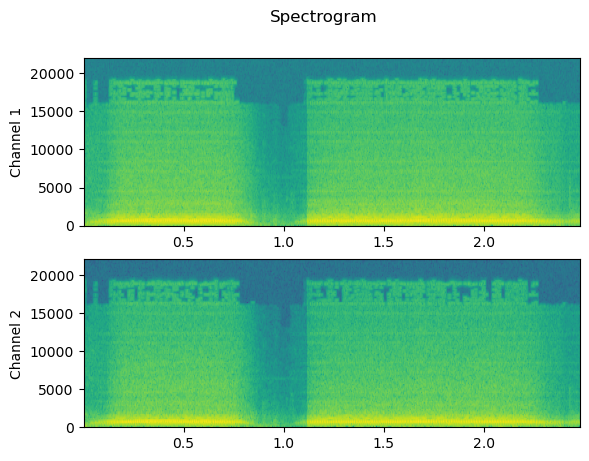

----------
Source: ./audio/PCM_S16.wav
----------
 - File size: 437516 bytes
 - AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)
----------
Source: ./audio/steam-train-whistle-daniel_simon.wav
----------
 - File size: 437516 bytes
 - AudioMetaData(sample_rate=44100, num_frames=109368, num_channels=2, bits_per_sample=16, encoding=PCM_S)


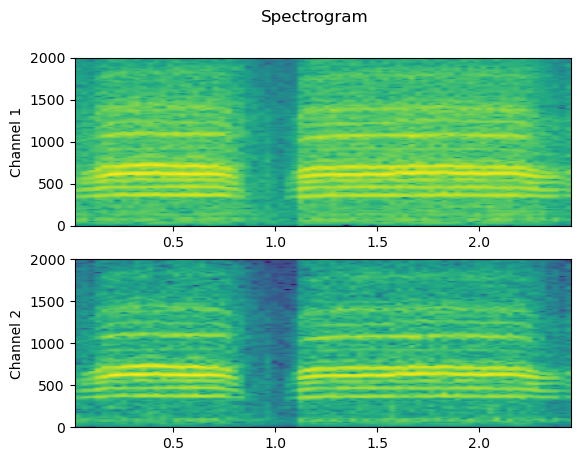

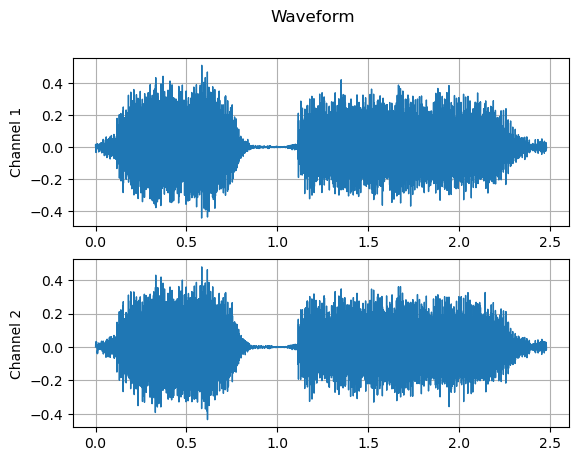

維度: (1, 513, 107)
資料型態: torch.float32
 - 最大值:         4000.533
 - 最小值:          0.000
 - 平均數:         5.726
 - 標準差: 70.301

tensor([[[7.8743e+00, 4.4462e+00, 5.6781e-01,  ..., 2.7694e+01,
          8.9546e+00, 4.1289e+00],
         [7.1094e+00, 3.2595e+00, 7.3520e-01,  ..., 1.7141e+01,
          4.4812e+00, 8.0840e-01],
         [3.8374e+00, 8.2490e-01, 3.0779e-01,  ..., 1.8502e+00,
          1.1777e-01, 1.2369e-01],
         ...,
         [3.4701e-07, 1.0604e-05, 1.2395e-05,  ..., 7.4091e-06,
          8.2059e-07, 1.0176e-05],
         [4.7174e-05, 4.4331e-07, 3.9444e-05,  ..., 3.0622e-05,
          3.9737e-07, 8.1568e-06],
         [1.3221e-04, 1.6440e-05, 7.2536e-05,  ..., 5.4662e-05,
          1.1663e-05, 2.5758e-06]]])



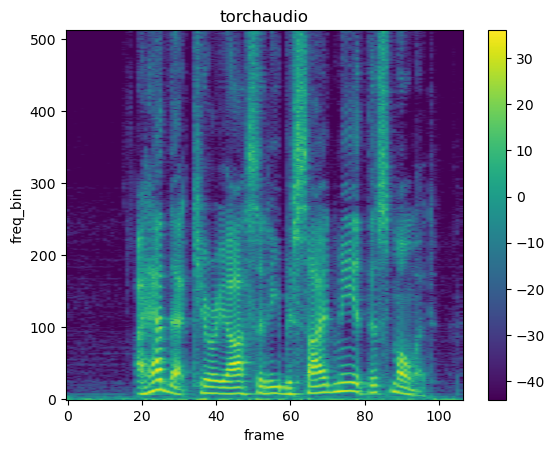

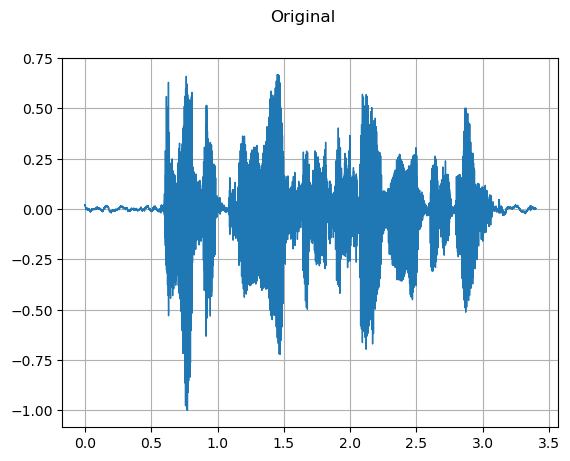

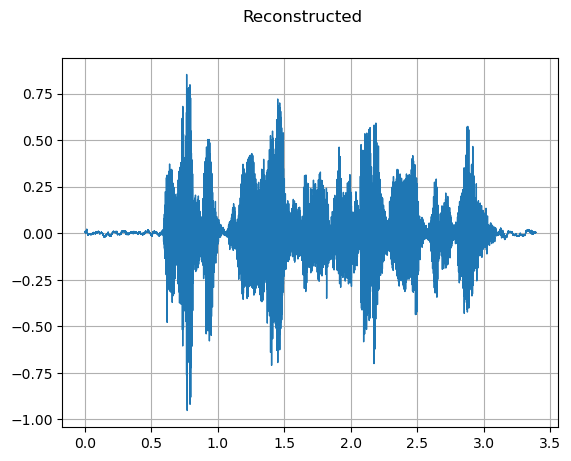

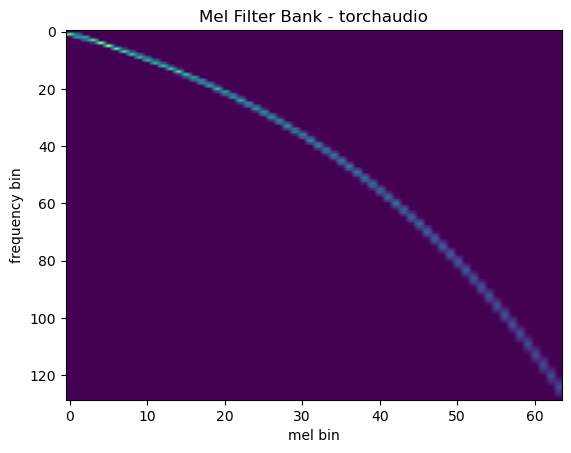

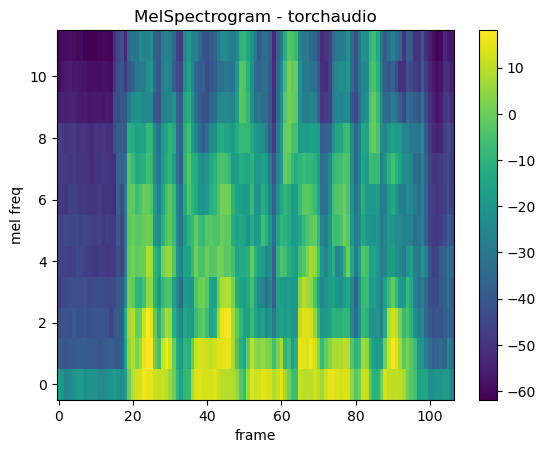

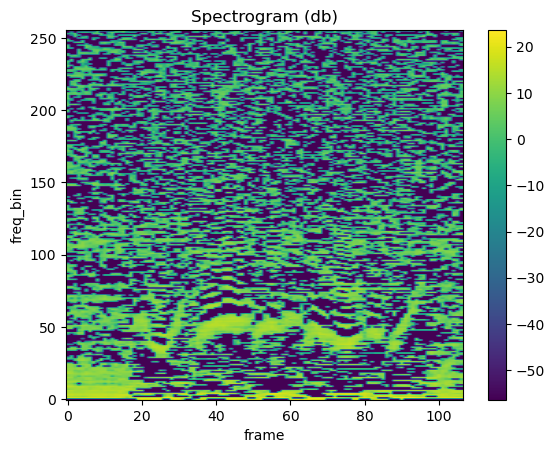

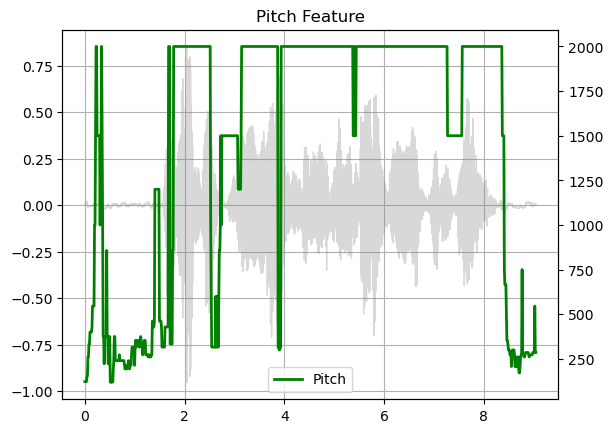

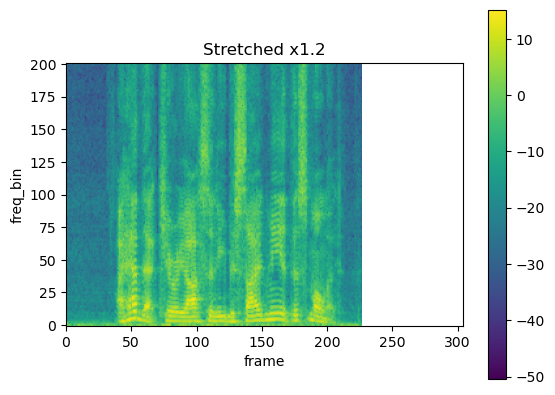

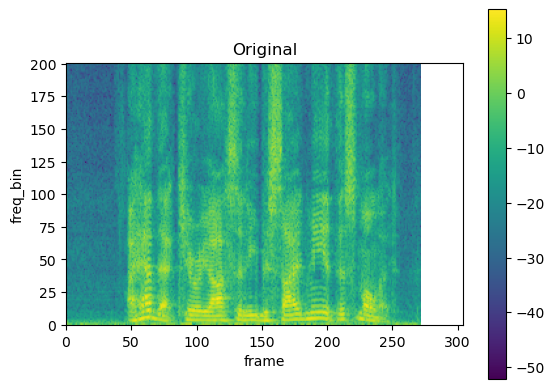

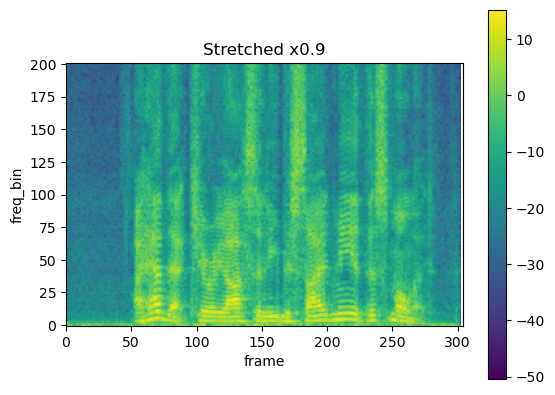

In [2]:
import torch
from torch import nn
import torchaudio
import torchaudio.transforms as T
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import IPython
from IPython.display import Audio
import matplotlib.pyplot as plt
import os
import math
import audio_util

In [97]:
PATH_DATASETS = "./audio" # 預設路徑
BATCH_SIZE = 5  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

In [98]:
dataset_GTZAN = torchaudio.datasets.GTZAN(PATH_DATASETS, folder_in_archive = 'archive/data/genres_original')


In [99]:
dataset_GTZAN[0]


(tensor([[ 0.0073,  0.0166,  0.0076,  ..., -0.0556, -0.0611, -0.0642]]),
 22050,
 'blues')

In [100]:
dataset_GTZAN[0][0].shape


torch.Size([1, 661794])

In [101]:
dataset_GTZAN[1][0].shape


torch.Size([1, 661794])

In [102]:
f'{661794 / 22050} 秒'


'30.013333333333332 秒'

In [103]:
gtzan_genres = [
    "blues",
    "classical",
    "country",
    "disco",
    "hiphop",
    "jazz",
    "metal",
    "pop",
    "reggae",
    "rock",
]



In [104]:
n_fft = 2048
hop_length = 512
n_mels = 256
n_mfcc = 256

class GTZAN_DS(Dataset):
    def __init__(self, dataset1):
        self.dataset1 = dataset_GTZAN
        
    def __len__(self):
          return len(self.dataset1)  

    def __getitem__(self, n):
        waveform , sample_rate, label = self.dataset1[n]
        mfcc_transform = T.MFCC(
            sample_rate=sample_rate,
            n_mfcc=n_mfcc,   
            melkwargs={
              'n_fft': n_fft,
              'n_mels': n_mels,
              'hop_length': hop_length,
              'mel_scale': 'htk',
            }
        )
        mfcc = mfcc_transform(waveform)
        mfcc = mfcc[:, :, :1280]
        return mfcc, gtzan_genres.index(label)
    
dataset = GTZAN_DS(dataset_GTZAN)

In [105]:
dataset.__getitem__(0)[0].size()

torch.Size([1, 256, 1280])

In [106]:
from torch.utils.data import random_split

test_size = int(len(dataset) * 0.2)
train_size = len(dataset) - test_size

train_ds, test_ds = random_split(dataset, [train_size, test_size])
len(train_ds), len(test_ds)

(800, 199)

In [107]:
train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, BATCH_SIZE*2, shuffle=False)

In [110]:
class ConvNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size = 5, stride = 1, padding = 2),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))    
        self.fc1 = nn.Linear(655360, num_classes)
        
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        #out = self.fc2(out)
        out = F.log_softmax(out, dim=1)
        return out
model = ConvNet().to(device)


In [112]:
epochs = 10
lr=0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.train()
loss_list = []    
for epoch in range(1, epochs + 1):
    for batch_idx, (data, target) in enumerate(train_loader):
        # if batch_idx == 0 and epoch == 1: print(type(data), type(target))
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        # if batch_idx == 0 : print(output.shape, target.shape)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if (batch_idx+1) % 10 == 0:
            loss_list.append(loss.item())
            batch = (batch_idx+1) * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * (batch_idx+1) / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f} %)' +
                  f'  Loss: {loss.item():.6f}')

Epoch 1: [   50 / 800] (6 %)  Loss: 1710.519897
Epoch 1: [  100 / 800] (12 %)  Loss: 730.860046
Epoch 1: [  150 / 800] (19 %)  Loss: 430.615295
Epoch 1: [  200 / 800] (25 %)  Loss: 159.615082
Epoch 1: [  250 / 800] (31 %)  Loss: 14.791865
Epoch 1: [  300 / 800] (38 %)  Loss: 137.478577
Epoch 1: [  350 / 800] (44 %)  Loss: 18.774916
Epoch 1: [  400 / 800] (50 %)  Loss: 35.030441
Epoch 1: [  450 / 800] (56 %)  Loss: 47.423626
Epoch 1: [  500 / 800] (62 %)  Loss: 15.636401
Epoch 1: [  550 / 800] (69 %)  Loss: 20.152853
Epoch 1: [  600 / 800] (75 %)  Loss: 9.711326
Epoch 1: [  650 / 800] (81 %)  Loss: 15.199048
Epoch 1: [  700 / 800] (88 %)  Loss: 19.816895
Epoch 1: [  750 / 800] (94 %)  Loss: 9.434450
Epoch 1: [  800 / 800] (100 %)  Loss: 3.104232
Epoch 2: [   50 / 800] (6 %)  Loss: 7.307677
Epoch 2: [  100 / 800] (12 %)  Loss: 3.425151
Epoch 2: [  150 / 800] (19 %)  Loss: 1.595039
Epoch 2: [  200 / 800] (25 %)  Loss: 1.126143
Epoch 2: [  250 / 800] (31 %)  Loss: 2.663801
Epoch 2: [  300 

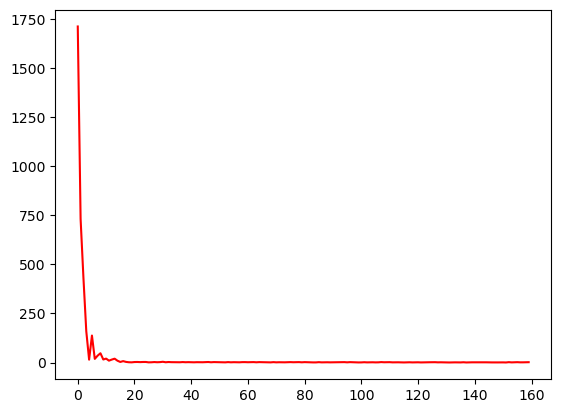

In [113]:
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')

In [114]:
model.eval()
test_loss = 0
correct = 0
predictions = []
target_list = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        
        test_loss += F.nll_loss(output, target).item()
        
        output = model(data)
        
        # 計算正確數
        _, predicted = torch.max(output.data, 1)
        predictions.extend(predicted.cpu().numpy())
        target_list.extend(target.cpu())
        correct += (predicted == target).sum().item()

test_loss /= len(test_loader.dataset) 
batch = batch_idx * len(data)
data_count = len(test_loader.dataset)
percentage = 100. * correct / data_count 
print(f'平均損失: {test_loss:.4f}, 準確率: {correct}/{data_count}' + 
      f' ({percentage:.2f}%)\n')

平均損失: 0.1769, 準確率: 80/199 (40.20%)



(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'blues'),
  Text(1, 0, 'classical'),
  Text(2, 0, 'country'),
  Text(3, 0, 'disco'),
  Text(4, 0, 'hiphop'),
  Text(5, 0, 'jazz'),
  Text(6, 0, 'metal'),
  Text(7, 0, 'pop'),
  Text(8, 0, 'reggae'),
  Text(9, 0, 'rock')])

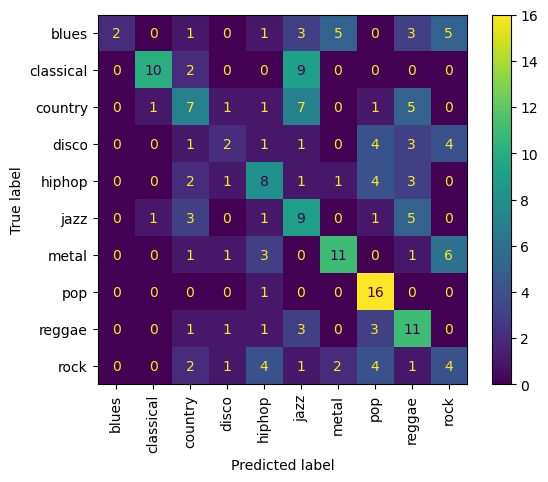

In [115]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(target_list, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gtzan_genres)
disp.plot()
plt.xticks(rotation=90)

# GTZAN_CNN_slicing

In [116]:
waveform , sample_rate, label = dataset_GTZAN[0]
segment_length = int(waveform.shape[1] / 5)
for i in range(5):
    audio_util.play_audio(waveform[:, i*segment_length:(i+1)*segment_length], sample_rate)
    print(waveform[:, i*segment_length:(i+1)*segment_length].shape[1])


132358


132358


132358


132358


132358


In [118]:
slice_count = 5
n_mfcc = 40

class GTZAN_DS(Dataset):
    def __init__(self, dataset1):
        self.dataset1 = dataset_GTZAN
        
    def __len__(self):
          return len(self.dataset1)  

    def __getitem__(self, n):
        waveform , sample_rate, label = self.dataset1[n]
            
        mfcc_transform = T.MFCC(
            sample_rate=sample_rate,
            n_mfcc=n_mfcc,   
        )
        
        mfcc_list=[]
        segment_length = int(waveform.shape[1] / slice_count)
        for i in range(5):
            mfcc = mfcc_transform(waveform[:, i*segment_length:(i+1)*segment_length])
            # print(mfcc.shape)
            mfcc_list.append(mfcc[:, :, :660])
            
        # 5段合成
        mfcc_tensor = torch.cat(mfcc_list, dim=0)
        return mfcc_tensor, gtzan_genres.index(label)
    
dataset = GTZAN_DS(dataset_GTZAN)

In [119]:
dataset[0][0].shape


C:\Users\ian\anaconda3\lib\site-packages\torchaudio\functional\functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


torch.Size([5, 40, 660])

In [120]:
from torch.utils.data import random_split

test_size = int(len(dataset) * 0.2)
train_size = len(dataset) - test_size

train_ds, test_ds = random_split(dataset, [train_size, test_size])
len(train_ds), len(test_ds)

(800, 199)

In [121]:
train_loader = DataLoader(train_ds, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, BATCH_SIZE, shuffle=False)

In [126]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(52800, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = F.log_softmax(out, dim=1)
        return out

model = ConvNet().to(device)

In [129]:
def score_model():
    model.eval()
    test_loss = 0
    correct = 0
    prediction_list = []
    target_list = []
    with torch.no_grad():
        for data, target in test_loader:
            target = target.repeat_interleave(slice_count)
            data = data.reshape(data.shape[0] * slice_count, 1, data.shape[2], data.shape[3])
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += F.nll_loss(output, target).item()

            output = model(data)

            _, predicted = torch.max(output.data, dim=1)
            correct += (predicted == target).sum().item()
            prediction_list.extend(predicted.cpu().numpy())
            target_list.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset) 
    batch = batch_idx * len(data)
    data_count = len(test_loader.dataset) * slice_count # 5倍筆數
    percentage = 100. * correct / data_count 
    print(f'平均損失: {test_loss:.4f}, 準確率: {correct}/{data_count}' + 
          f' ({percentage:.2f}%)\n')
    return prediction_list, target_list

In [130]:
epochs = 40
lr=0.01

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_list = []    
for epoch in range(1, epochs + 1):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.repeat_interleave(slice_count)
        data = data.reshape(data.shape[0] * slice_count, 1, data.shape[2], data.shape[3])
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        if (batch_idx+1) % 10 == 0:
            loss_list.append(loss.item())
            batch = (batch_idx+1) * len(data)
            data_count = len(train_loader.dataset) * slice_count
            percentage = (100. * (batch_idx+1) / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f} %)' +
                  f'  Loss: {loss.item():.6f}')
    score_model()

Epoch 1: [  250 / 4000] (6 %)  Loss: 3.417590
Epoch 1: [  500 / 4000] (12 %)  Loss: 2.556499
Epoch 1: [  750 / 4000] (19 %)  Loss: 2.191616
Epoch 1: [ 1000 / 4000] (25 %)  Loss: 1.778230
Epoch 1: [ 1250 / 4000] (31 %)  Loss: 1.789834
Epoch 1: [ 1500 / 4000] (38 %)  Loss: 2.271001
Epoch 1: [ 1750 / 4000] (44 %)  Loss: 1.866990
Epoch 1: [ 2000 / 4000] (50 %)  Loss: 2.650720
Epoch 1: [ 2250 / 4000] (56 %)  Loss: 2.268172
Epoch 1: [ 2500 / 4000] (62 %)  Loss: 1.967973
Epoch 1: [ 2750 / 4000] (69 %)  Loss: 2.057658
Epoch 1: [ 3000 / 4000] (75 %)  Loss: 2.203649
Epoch 1: [ 3250 / 4000] (81 %)  Loss: 1.733695
Epoch 1: [ 3500 / 4000] (88 %)  Loss: 1.710985
Epoch 1: [ 3750 / 4000] (94 %)  Loss: 2.255081
Epoch 1: [ 4000 / 4000] (100 %)  Loss: 2.308874
平均損失: 0.4596, 準確率: 140/995 (14.07%)

Epoch 2: [  250 / 4000] (6 %)  Loss: 2.213097
Epoch 2: [  500 / 4000] (12 %)  Loss: 2.402337
Epoch 2: [  750 / 4000] (19 %)  Loss: 1.745330
Epoch 2: [ 1000 / 4000] (25 %)  Loss: 1.799109
Epoch 2: [ 1250 / 4000] 

Epoch 11: [ 1750 / 4000] (44 %)  Loss: 1.755964
Epoch 11: [ 2000 / 4000] (50 %)  Loss: 1.485969
Epoch 11: [ 2250 / 4000] (56 %)  Loss: 1.755224
Epoch 11: [ 2500 / 4000] (62 %)  Loss: 1.732025
Epoch 11: [ 2750 / 4000] (69 %)  Loss: 1.220610
Epoch 11: [ 3000 / 4000] (75 %)  Loss: 1.473576
Epoch 11: [ 3250 / 4000] (81 %)  Loss: 1.341772
Epoch 11: [ 3500 / 4000] (88 %)  Loss: 1.228356
Epoch 11: [ 3750 / 4000] (94 %)  Loss: 1.715174
Epoch 11: [ 4000 / 4000] (100 %)  Loss: 1.273912
平均損失: 0.4591, 準確率: 282/995 (28.34%)

Epoch 12: [  250 / 4000] (6 %)  Loss: 1.466059
Epoch 12: [  500 / 4000] (12 %)  Loss: 1.757560
Epoch 12: [  750 / 4000] (19 %)  Loss: 1.021636
Epoch 12: [ 1000 / 4000] (25 %)  Loss: 1.082910
Epoch 12: [ 1250 / 4000] (31 %)  Loss: 1.417508
Epoch 12: [ 1500 / 4000] (38 %)  Loss: 1.991153
Epoch 12: [ 1750 / 4000] (44 %)  Loss: 1.837158
Epoch 12: [ 2000 / 4000] (50 %)  Loss: 1.403798
Epoch 12: [ 2250 / 4000] (56 %)  Loss: 1.636855
Epoch 12: [ 2500 / 4000] (62 %)  Loss: 1.716074
Epo

Epoch 21: [ 2500 / 4000] (62 %)  Loss: 1.320825
Epoch 21: [ 2750 / 4000] (69 %)  Loss: 1.424688
Epoch 21: [ 3000 / 4000] (75 %)  Loss: 0.434399
Epoch 21: [ 3250 / 4000] (81 %)  Loss: 2.346505
Epoch 21: [ 3500 / 4000] (88 %)  Loss: 1.514955
Epoch 21: [ 3750 / 4000] (94 %)  Loss: 2.110520
Epoch 21: [ 4000 / 4000] (100 %)  Loss: 2.056825
平均損失: 0.4307, 準確率: 305/995 (30.65%)

Epoch 22: [  250 / 4000] (6 %)  Loss: 1.412695
Epoch 22: [  500 / 4000] (12 %)  Loss: 1.643548
Epoch 22: [  750 / 4000] (19 %)  Loss: 0.840946
Epoch 22: [ 1000 / 4000] (25 %)  Loss: 1.063219
Epoch 22: [ 1250 / 4000] (31 %)  Loss: 1.352754
Epoch 22: [ 1500 / 4000] (38 %)  Loss: 1.683141
Epoch 22: [ 1750 / 4000] (44 %)  Loss: 1.367588
Epoch 22: [ 2000 / 4000] (50 %)  Loss: 0.564238
Epoch 22: [ 2250 / 4000] (56 %)  Loss: 0.959188
Epoch 22: [ 2500 / 4000] (62 %)  Loss: 1.191237
Epoch 22: [ 2750 / 4000] (69 %)  Loss: 1.470527
Epoch 22: [ 3000 / 4000] (75 %)  Loss: 0.406475
Epoch 22: [ 3250 / 4000] (81 %)  Loss: 2.013296
Epo

Epoch 31: [ 3250 / 4000] (81 %)  Loss: 0.777043
Epoch 31: [ 3500 / 4000] (88 %)  Loss: 0.779678
Epoch 31: [ 3750 / 4000] (94 %)  Loss: 1.695745
Epoch 31: [ 4000 / 4000] (100 %)  Loss: 1.967719
平均損失: 0.4100, 準確率: 306/995 (30.75%)

Epoch 32: [  250 / 4000] (6 %)  Loss: 1.033337
Epoch 32: [  500 / 4000] (12 %)  Loss: 1.547745
Epoch 32: [  750 / 4000] (19 %)  Loss: 1.109582
Epoch 32: [ 1000 / 4000] (25 %)  Loss: 1.044192
Epoch 32: [ 1250 / 4000] (31 %)  Loss: 1.481764
Epoch 32: [ 1500 / 4000] (38 %)  Loss: 1.247139
Epoch 32: [ 1750 / 4000] (44 %)  Loss: 1.139301
Epoch 32: [ 2000 / 4000] (50 %)  Loss: 0.383319
Epoch 32: [ 2250 / 4000] (56 %)  Loss: 0.495772
Epoch 32: [ 2500 / 4000] (62 %)  Loss: 0.482354
Epoch 32: [ 2750 / 4000] (69 %)  Loss: 1.373920
Epoch 32: [ 3000 / 4000] (75 %)  Loss: 0.265186
Epoch 32: [ 3250 / 4000] (81 %)  Loss: 0.791164
Epoch 32: [ 3500 / 4000] (88 %)  Loss: 0.492297
Epoch 32: [ 3750 / 4000] (94 %)  Loss: 1.641897
Epoch 32: [ 4000 / 4000] (100 %)  Loss: 2.000344
平均

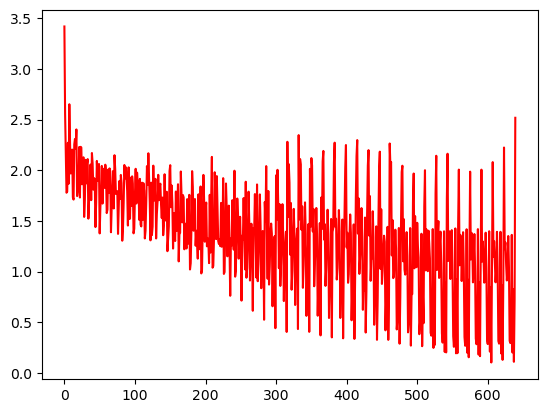

In [135]:
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')

In [132]:
prediction_list, target_list = score_model()


平均損失: 0.5505, 準確率: 320/995 (32.16%)



(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'blues'),
  Text(1, 0, 'classical'),
  Text(2, 0, 'country'),
  Text(3, 0, 'disco'),
  Text(4, 0, 'hiphop'),
  Text(5, 0, 'jazz'),
  Text(6, 0, 'metal'),
  Text(7, 0, 'pop'),
  Text(8, 0, 'reggae'),
  Text(9, 0, 'rock')])

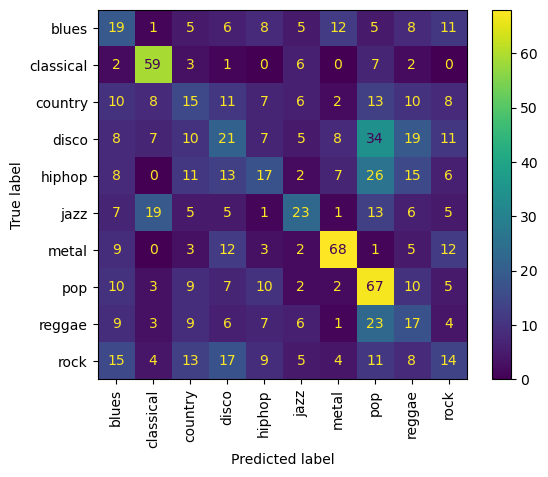

In [133]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(target_list, prediction_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gtzan_genres)
disp.plot()
plt.xticks(rotation=90)

In [134]:
predictions = []
target_list = []
with torch.no_grad():
    for i in range(20):
        data, target = test_ds[i]
        data = data.reshape(slice_count, 1, data.shape[1], data.shape[2])
        data = data.to(device)
        output = torch.argmax(model(data), axis=-1)
        predictions.append(str(output.cpu().numpy()[0]))
        target_list.append(str(target))

# 比對
print('actual    :', ' '.join(target_list))
print('prediction:', ' '.join(predictions[0:20]))

C:\Users\ian\anaconda3\lib\site-packages\torchaudio\functional\functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


actual    : 4 3 8 4 7 7 1 0 2 6 3 3 6 0 2 4 2 5 7 6
prediction: 7 7 2 7 7 7 1 0 1 6 3 4 9 6 5 7 8 7 7 6
